# 2. Introduction to msprime

1. [Why use msprime?](#why_use_msprime)
2. [Getting started](#getting_started)
3. [Recombination](#recombination)
4. [Mutation](#mutation)
5. [Population structure](#population_structure)
6. [Migration](#migration)
7. [Changing population sizes or growth rates](#change_pop_size_and_growth)
8. [The demography debugger](#demography_debugger)

<a id='why_use_msprime'></a>
## 2.1 Why use msprime?

This notebook introduces `msprime` [[1](https://msprime.readthedocs.io/en/stable/introduction.html)], an reimplementation of Hudson's `ms` program [[2](http://home.uchicago.edu/~rhudson1/source/mksamples.html)] for simulating genomic datasets under the coalescent model with recombination. msprime is capable of simulating sample sizes far larger than any other simulators, and is generally extremely efficient. Because it simulates datasets with the tree sequence structure, extracting statistics from the simulations is generally also extremely quick. We will see that it can easily simulate chromosome-sized regions for hundreds of thousands of samples, allowing us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance on a scale that was previously impossible.
 
### The coalescent model with recombination
 
*The coalescent* [3] is a model of the historical processes that generate genetic variation and genealogies. We are lucky to have many readable guides to coalescent theory today; one that is freely available online is [[4](https://github.com/cooplab/popgen-notes)].
 
The coalescent model makes a few assumptions that are important to keep in mind:
 - infinite sites: no site acquires more than one mutation.
 - Random mating within populations
 - Small sample sizes relative to population
 - No selection
 
### Other references

[1] Kelleher, J., Etheridge, A. M., & McVean, G. (2016). Efficient Coalescent Simulation and Genealogical Analysis for Large Sample Sizes. PLOS Computational Biology, 12(5), e1004842. https://doi.org/10.1371/journal.pcbi.1004842

[2] Hudson, R. R. (2002) Generating samples under a Wright-Fisher neutral model. Bioinformatics 18:337-8.

[3] Kingman JFC. The coalescent. Stoch Proc Appl. 1982; 13(3):235–248. doi: 10.1016/0304-4149(82) 90011-4

[4] Coop, G. Population and Quantitative Genetics. (March 2019). Available online at [https://github.com/cooplab/popgen-notes](https://github.com/cooplab/popgen-notes).

<a id='getting_started'></a>
## 2.2 Getting started

In [1]:
import msprime
import numpy as np
from IPython.display import SVG

### A simple simulation

The minimal input into msprime is a sample size. Let's simulate a small sample of 6 chromosomes to start off with. We'll use this to illustrate some basic features of msprime simulations.

The `simulate` function returns a `TreeSequence` object, which provides a very efficient way to access the correlated trees in simulations involving recombination. 

In [2]:
ts = msprime.simulate(sample_size = 6, random_seed = 1)

Number of trees in tree sequence: 1
Length of simulated sequence: 1.0


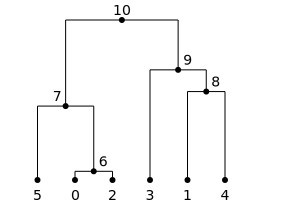

In [3]:
print("Number of trees in tree sequence:", ts.num_trees)
print("Length of simulated sequence:", ts.sequence_length)
display(SVG(ts.first().draw(width=300)))

Notice that there is only a single tree in our simulated tree sequence. This is because we have not yet provided a value for the `recombination_rate`, and it defaults to zero.

### Sequence length

Because we also haven't specified a sequence length, our simulated sequence will have length 1. 

In [4]:
ts.sequence_length

1.0

It is usually most convenient to set the sequence length to be the number of nucleotide bases in the desired simulated sequence. We use the `length` input to specify this.

In [5]:
ts = msprime.simulate(sample_size = 6, random_seed = 1, length = 1000)
print("Length of simulated sequence:", ts.sequence_length)

Length of simulated sequence: 1000.0


### Effective population sizes and times in msprime

Recall that each tree sequence has an equivalent representation as a set of tables. Let's have a look at some of these tables now to get a sense of the timescale over which we have just simulated.

In [6]:
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	1	0	-1	0.00000000000000	
6	0	0	-1	0.07194744353492	
7	0	0	-1	0.61124301112428	
8	0	0	-1	0.73124726040958	
9	0	0	-1	0.91078323219376	
10	0	0	-1	1.32301250012150	


The first six nodes with `time = 0.0` correspond to the samples. 
All other nodes correspond to *ancestors* of the samples, and so have positive times. 
The reason why the node times in our simple example are so small is because, by default, msprime assumes a constant (diploid) effective population size of Ne = 1, which is equivalent to measuring time in units of Ne generations.

While this scaling can be useful when comparing simulations against analytic results from coalescent theory, it's often simpler to think of time in units of *generations backwards-in-time*.
We can do this be specifying our desired effective population size using the `Ne` input into `simulate`:

In [7]:
ts = msprime.simulate(sample_size = 6, random_seed = 1, Ne = 10000)
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	1	0	-1	0.00000000000000	
6	0	0	-1	719.47443534915067	
7	0	0	-1	6112.43011124283566	
8	0	0	-1	7312.47260409581213	
9	0	0	-1	9107.83232193760159	
10	0	0	-1	13230.12500121500307	


Recall that under the coalescent model, each simulated ancestral node represents a *coalescence event* at which two lineages converge. These coalescences should occur less frequently in a larger population. As expected, rescaling our effective population size has also rescaled our coalescence times by the same factor!

Hopefully, you can already see that simulations with `msprime` can help us clarify our intuition about how the coalescent model works.

### Random seeds

In general, running the same `msprime` commands multiple times will produce different outputs.
To ensure the same output, you can specify a random seed. 

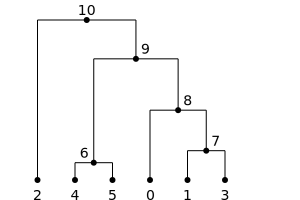

In [8]:
ts = msprime.simulate(sample_size = 6, random_seed = 10,  Ne = 10000)

for tree in ts.trees():
    display(SVG(tree.draw(width=300)))

<a id='recombination'></a>
## 2.3 Recombination

We can simulate entire chromosome-sized sequences with msprime. To do this, we will often want to add in a model of recombination.

### Uniform recombination

To simulate with a constant recombination rate, we specify two extra inputs to `simulate`: a sequence `length` (most easily specified as a number of bases) and a `recombination_rate` (specified as the rate of crossovers per unit of length per generation).

Tree on interval (0.0, 181.74732201307717)


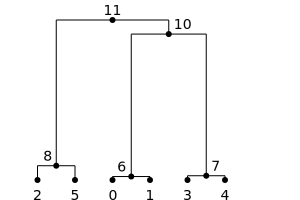

Tree on interval (181.74732201307717, 1000.0)


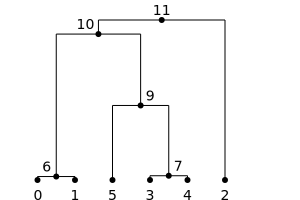

In [9]:
ts = msprime.simulate(sample_size = 6, random_seed = 12, length = 1000, recombination_rate = 1e-4 )

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

### Non-uniform recombination

It's also possible to simulate under a variable rate of recombination.
To do this, we can specify an external recombination map given as a `RecombinationMap` object.
See the [msprime documentation](https://msprime.readthedocs.io/en/stable/api.html?highlight=RecombinationMap#msprime.RecombinationMap) for more information about these objects.

In [10]:
# Making a simple RecombinationMap object.
map_positions = [i*100 for i in range(0, 11)]
map_rates = [0, 1e-4, 5e-4, 1e-4, 0, 0, 0, 5e-4, 6e-4, 1e-4, 0]
my_map = msprime.RecombinationMap(map_positions, map_rates)

# Simulating with the recombination map.
ts = msprime.simulate(sample_size = 6, random_seed = 12, recombination_map = my_map)

<a id='mutation'></a>
## 2.4 Mutation

To simulate genetic variation, we'll need to add some mutations to our tree sequences. Mutations are generated in msprime by sprinkling mutations over the branches of trees at a rate specified by the `mutation_rate` input to `simulate`. 

Tree on interval (0.0, 181.74732201307717)


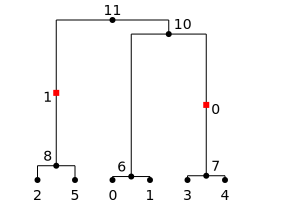

Tree on interval (181.74732201307717, 1000.0)


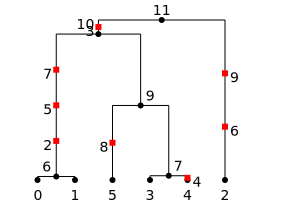

In [11]:
ts = msprime.simulate(sample_size = 6, random_seed = 12, length = 1000, recombination_rate = 1e-4, mutation_rate = 7e-4)

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

The mutations are generated under the infinite sites model, and so each mutation occurs at a unique (floating point) point position along the simulated sequence. 

### Accessing the simulated variants

We may want to directly analyse the sequence data that results from simulations.
The most efficient way to do this is with the `variants()` method, which returns an iterator over all the mutated sites. Each variant contains a reference to the site object, as well as the alleles and the observed sequences for each sample in the genotypes field:

In [12]:
print('Site ID\t', 'Site position\t\t', 'Alleles\t', 'Genotypes\t')
for var in ts.variants():
    print(var.site.id, var.site.position, var.alleles, var.genotypes, sep="\t")

Site ID	 Site position		 Alleles	 Genotypes	
0	127.69973140085281	('0', '1')	[0 0 0 1 1 0]
1	139.48664451133118	('0', '1')	[0 0 1 0 0 1]
2	289.5867882762104	('0', '1')	[1 1 0 0 0 0]
3	406.6403051838279	('0', '1')	[1 1 0 1 1 1]
4	456.05092123150826	('0', '1')	[0 0 0 0 1 0]
5	471.22978256084025	('0', '1')	[1 1 0 0 0 0]
6	692.8133055495289	('0', '1')	[0 0 1 0 0 0]
7	816.1682989448309	('0', '1')	[1 1 0 0 0 0]
8	953.5049363062362	('0', '1')	[0 0 0 0 0 1]
9	982.0459640208176	('0', '1')	[0 0 1 0 0 0]


Note that `var.alleles[var.genotypes[j]]` gives the allele of sample ID j at variant `var`.
By default, `msprime` labels the wildtype allele `'0'` and the mutated type allele `'1'`.

(Can these be changed to explicitly show nucleotide bases somehow?)

If we want a numpy array containing all sample genotypes at all variant sites, we can get it using the `genotype_matrix()` method:

In [13]:
ts.genotype_matrix()

array([[0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0]], dtype=uint8)

Beware that this matrix might be very big (bigger than the tree sequence it's extracted from, in most realistically-sized simulations!)

<a id='population_structure'></a>
## 2.5 Population structure

So far, we've been simulating samples from a single population of a constant size, which isn't particularly exciting!
One of the strengths of msprime is that it can be used to specify quite complicated models of demography and population history with a simple Python API. 
We'll see how to do this now.

### Population configurations

msprime supports simulation from multiple discrete populations, each of which is initialized with a `PopulationConfiguration` object.
For each population, you can specify a sample size, an effective population size at time = 0 and an exponential growth rate.

Say we wanted to simulate three sequences each from two populations with a constant effective population size of 500.

In [14]:
pop0 = msprime.PopulationConfiguration(sample_size=3, initial_size = 500, growth_rate = 0.00)
pop1 = msprime.PopulationConfiguration(sample_size=3, initial_size = 500, growth_rate = 0.00)

You can give these to msprime as a list of `population_configurations`. (Note that we no longer need to specify `Ne` as we have provided a separate size for each population).

In [15]:
# ts = msprime.simulate(population_configurations = [pop0, pop1], random_seed = 12, length = 1000, 
#                       recombination_rate = 1e-4, mutation_rate = 7e-4)

However, this simulation will run forever unless we also specify some migration between the groups!

<a id='migration'></a>
## 2.6 Migrations

With msprime, you can specify continual rates of migrations between populations, as well as one-off mass migrations.

### Constant migration


<p><img src="pics/population-structure-1.png" alt="" width="50%"/></p>

Migration rates between the populations can be specified as the elements of an *N* by *N*  numpy array, and given to `simulate` via the `migration_matrix` input. The diagonal elements of this array must each be 0, and `M[i][j]` specifies the fraction of population `i` that consists of new migrants from population `j` in each generation.

For instance, this migration matrix specifies that in each generation, 5% of population 0 consists of migrants from population 1, and 2% of population 1 consists of migrants from population 0.

In [16]:
M = np.array([
[0, 0.05],
[0.02, 0]])

In [17]:
ts = msprime.simulate(population_configurations = [pop0, pop1], migration_matrix = M, length = 1000, 
                     random_seed = 17, recombination_rate = 1e-6)

One consequence of specifying PopulationConfigurations is that each of the simulated nodes will now belong to one of our specified populations:

In [18]:
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	1	-1	0.00000000000000	
4	1	1	-1	0.00000000000000	
5	1	1	-1	0.00000000000000	
6	0	0	-1	11.88714489632197	
7	0	1	-1	224.72850970133027	
8	0	1	-1	506.90932379996059	
9	0	1	-1	511.57254860439127	
10	0	1	-1	784.83535186047050	
11	0	1	-1	1072.51298319552620	
12	0	1	-1	1996.87609920001410	
13	0	1	-1	2117.29937132254372	
14	0	1	-1	2142.22807873149350	
15	0	1	-1	3708.68788078834223	


Tree on interval: (0.0, 50.87349192492512)


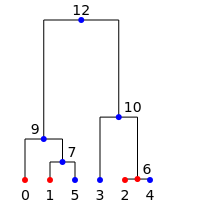

Tree on interval: (50.87349192492512, 365.4655284167886)


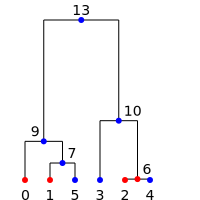

Tree on interval: (365.4655284167886, 558.1932856138314)


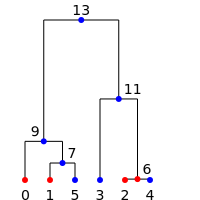

Tree on interval: (558.1932856138314, 754.3368171328532)


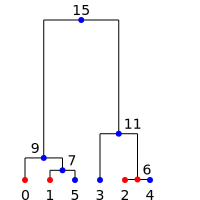

Tree on interval: (754.3368171328532, 755.8673305334215)


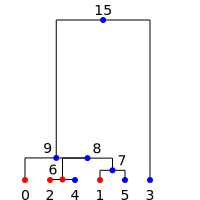

Tree on interval: (755.8673305334215, 890.9437884322703)


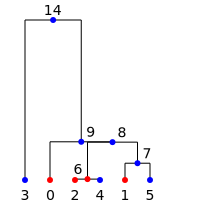

Tree on interval: (890.9437884322703, 1000.0)


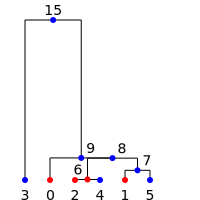

In [19]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}

for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    display(SVG(tree.draw(node_colours=node_colours)))

More coalescences are happening in population 1 than population 0. 
This makes sense given that population 1 is specifying more migrants to population 0 than vice versa.

### Changing the migration rate

<p><img src="pics/population-structure-2.png" alt="" width="50%"/></p>

We can change any of the migration rates at any time in the simulation.
To do this, we just need to add a `MigrationRateChange` object specifying the index of the migration matrix to be changed, the time of the change and the new migration rate.

For instance, say we wanted to specify that in each generation prior to time = 100, 1% of population 0 consisted of migrants from population 1.

In [20]:
migration_rate_change = msprime.MigrationRateChange(time = 100, rate = 0.01, matrix_index=(0, 1))

A list of these changes can be supplied to `simulate` via the `demographic events` input:
(If there is more than 1 change, ensure they are ordered by backwards-time!)

In [21]:
ts = msprime.simulate(
    population_configurations = [pop0, pop1], 
    migration_matrix = M, 
    length = 1000, 
    demographic_events = [migration_rate_change], 
    random_seed = 25, 
    recombination_rate = 1e-6)

#### Exercise: 

<p><img src="pics/population-structure-exercise-1.png" alt="" width="50%"/></p>

In the code below, we have specified an two-population island model. Can you turn this into a three-population island model? 
If you get time, try to plot the tree sequence.

In [22]:
pop_configs_ex = [
    msprime.PopulationConfiguration(sample_size=3, initial_size = 500, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=3, initial_size = 500, growth_rate = 0)]

migration_rates_ex = np.array([
[0, 0.05],
[0.02, 0]])

demographic_events_ex = [
    msprime.MigrationRateChange(time = 100, rate = 0.01, matrix_index=(0, 1))]

# Simulate!
ts_ex = msprime.simulate(
    population_configurations = pop_configs_ex, 
    migration_matrix = migration_rates_ex, 
    length = 1000, 
    demographic_events = demographic_events_ex, 
    recombination_rate = 1e-6
)

### Mass migration

`MassMigration` objects are used to specify one-off events in which some fraction of a population moves into another population. 
These are useful for specifying divergence and admixture events.

You'll need to provide the time of the event in generations, as well as the ID of the `source` and `dest`ination populations, as well as a migration proportion (which defaults to 1.0).
Note that these are viewed as backwards-in-time events, so `source` is the population that receives migrants from `dest`.

<p><img src="pics/population-structure-3.png" alt="" width="50%"/></p>

For example, the following specifies that 50 generations ago, 30% of population 0 was a migrant from population 1.

In [23]:
admixture_event  = msprime.MassMigration(time = 50, source = 0, dest = 1, proportion = 0.3)

Any `MassMigration`s can be added into the list of `demographic_events` supplied to `simulate`.

In [24]:
ts = msprime.simulate(population_configurations = [pop0, pop1], migration_matrix = M, 
                      demographic_events = [admixture_event],
                      random_seed = 12, length = 1000, recombination_rate = 1e-4, mutation_rate = 7e-4)

`MassMigration` objects can also be used to specify divergence events, but we must take some care.

The following specifies that 200 generations ago, 100% of population 1 was a migrant from population 0.

In [25]:
divergence_event = msprime.MassMigration(time = 200, source = 1, dest = 0, proportion = 1)

We'll add this to our list of `demographic_events`.

In [26]:
ts = msprime.simulate(population_configurations = [pop0, pop1], migration_matrix = M, 
                      demographic_events = [admixture_event, divergence_event],
                      random_seed = 14, length = 1000, recombination_rate = 1e-6)

However, when we look at the population IDs corresponding to the the nodes from more than 200 generations ago, there are still some nodes from both populations. 
This is not what what we'd expect to see if we'd correctly simulated a divergence event!

In [27]:
[u.population for u in ts.nodes() if u.time > 200]

[0, 0, 0, 0, 1, 1, 1, 1]

The reason is that at present, we are simulating a situation in which population 1 exists prior to generation 200, but is completely replaced by migrants from population 0 at time = 200. And because we've specified a migration matrix, there will still be some migrants from population 0 to population 1 in prior generations. 

<p><img src="pics/population-structure-4.png" alt="" width="50%"/></p>

We can fix this by also specifying that prior to time = 200, population 1 had no migration from population 0. 

In [28]:
divergence_rate_change = msprime.MigrationRateChange(time = 200, rate = 0, matrix_index=None)

In [29]:
ts = msprime.simulate(population_configurations = [pop0, pop1], migration_matrix = M, 
                      demographic_events = [admixture_event, divergence_event, divergence_rate_change],
                      random_seed = 14, length = 1000, recombination_rate = 1e-6)

Now all ancestral nodes prior to generation 200 are exclusively from population 0. Hooray!

<p><img src="pics/population-structure-5.png" alt="" width="50%"/></p>

In [30]:
[u.population for u in ts.nodes() if u.time > 200]

[0, 0, 0, 0, 0, 0, 0, 0]

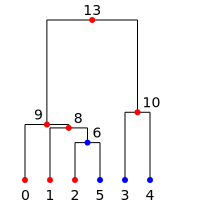

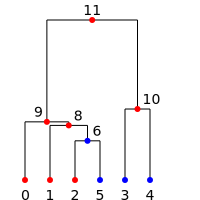

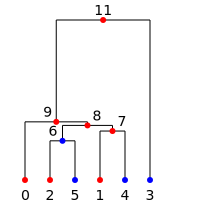

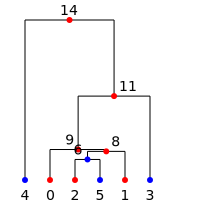

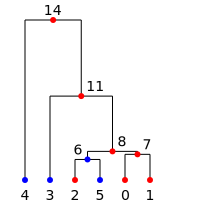

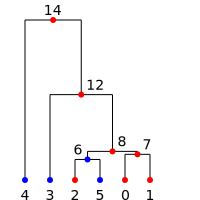

In [31]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}

for tree in ts.trees():
    display(SVG(tree.draw(node_colours=node_colours)))

<a id='change_pop_size_and_growth'></a>
## 2.7 Changing population sizes or growth rates

<p><img src="pics/population-structure-6.png" alt="" width="50%"/></p>

We may wish to specify changes to rates of population growth, or sudden changes in population size at a particular time. Both of these can be specified with `PopulationParametersChange` objects in the list of `demographic_events`.

In [32]:
# Bottleneck in Population 0 between 50 - 150 generations ago.
pop0_bottleneck_ends = msprime.PopulationParametersChange(
    time = 50, initial_size = 250, population = 0)
pop0_bottleneck_starts = msprime.PopulationParametersChange(
    time = 150, initial_size = 500, population = 0)

# Exponential growth in Population 1 starting 50 generations ago.
pop1_recent_growth = msprime.PopulationParametersChange(
    time = 100, growth_rate = 0.01, population = 1)

In [33]:
ts = msprime.simulate(
    population_configurations = [pop0, pop1], migration_matrix = M, length = 1000,
    demographic_events = [pop0_bottleneck_ends, pop1_recent_growth, pop0_bottleneck_starts],
    random_seed = 17, recombination_rate = 1e-6)

<a id='demography_debugger'></a>
## 2.8 Using the Demography Debugger

As we've seen, it's pretty easy to make mistakes when specifying demography!

To help you spot these, `msprime` provides a debugger that prints out your population history in a more human-readable form. It's good to get into the habit of running this debugger before running your simulations.

In [34]:
my_history = msprime.DemographyDebugger(
    population_configurations=[pop0, pop1], migration_matrix = M, 
    demographic_events=[admixture_event, divergence_event, divergence_rate_change])

my_history.print_history()

Epoch: 0 -- 50.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   500      500                0 |     0      0.05   
1 |   500      500                0 |   0.02       0    

Events @ generation 50.0
   - Mass migration: lineages move from 0 to 1 with probability 0.3
Epoch: 50.0 -- 200.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   500      500                0 |     0      0.05   
1 |   500      500                0 |   0.02       0    

Events @ generation 200.0
   - Mass migration: lineages move from 1 to 0 with probability 1
   - Migration rate change to 0 everywhere
Epoch: 200.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   500      500                0 |     0        0    
1 |   500      500                0 |     0      

#### Exercising: simulating population divergence

<p><img src="pics/population-structure-exercise-2.png" alt="" width="50%"/></p>

The code below specifies a simulation of two populations in which population 1 diverges from population 0 at time 200.

Can you add a third population, population 2, that diverges from population 1 at time 150?

In [35]:
pop_configs_ex = [
    msprime.PopulationConfiguration(sample_size=3, initial_size = 500, growth_rate = 0.01),
    msprime.PopulationConfiguration(sample_size=3, initial_size = 500, growth_rate = 0.01)]

migration_rates_ex = np.array([
[0, 0],
[0, 0]])

demographic_events_ex = [
    msprime.MassMigration(time = 200, source = 1, dest = 0, proportion = 1)]

# Simulate!
ts_ex = msprime.simulate(
    population_configurations = pop_configs_ex, 
    migration_matrix = migration_rates_ex, 
    length = 1000, 
    demographic_events = demographic_events_ex, 
    recombination_rate = 1e-6
)